In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from collections import deque
import os

In [2]:
def generate_ar1(n=1000, rho1=0.5, rho2 = 0.2, rho3=-0.1):
    x = np.random.randn(n)
    error = np.random.randn(n)
    for i in range(3,n):
        x[i] = rho1*x[i-1] +rho2*x[i-2] + rho3*x[i-3] +  error[i]
    return x

In [3]:
count=0
for i in range(1):
    ar1 = generate_ar1(1000,0.6,0.2)
#     print(ar1[:5])
#     pd.DataFrame(ar1).plot(figsize=(12,9))
    model = AR(ar1)
    fit = model.fit(ic='bic')
    print(fit.normalized_cov_params)
    print(fit.params)
    
    if fit.k_ar != 2:
        print(fit.k_ar)
        count += 1
print("count is %d"%count)

[[ 1.00420256e-03  1.07007555e-05  6.89590663e-06  1.22003794e-05]
 [ 1.07007555e-05  9.78763118e-04 -5.73063381e-04 -1.11123444e-04]
 [ 6.89590663e-06 -5.73063381e-04  1.29989608e-03 -5.71331542e-04]
 [ 1.22003794e-05 -1.11123444e-04 -5.71331542e-04  9.77138449e-04]]
[-0.01057791  0.59740014  0.18724042 -0.12222566]
3
count is 1


In [4]:
df = pd.read_csv("../data/NIFTY 50.csv", index_col='Date')
cl = pd.DataFrame(df['Close'])
cl['logClose'] = np.log(cl['Close'])
cl['diffLogClose'] = cl['logClose'] - cl['logClose'].shift(1)
cl['pctChange'] = cl['Close'].pct_change()
cl = cl.dropna()
print(cl.head())
print(cl.tail())

              Close  logClose  diffLogClose  pctChange
Date                                                  
2006-01-03  2883.35  7.966708      0.016576   0.016714
2006-01-04  2904.40  7.973982      0.007274   0.007301
2006-01-05  2899.85  7.972414     -0.001568  -0.001567
2006-01-06  2914.00  7.977282      0.004868   0.004880
2006-01-09  2910.10  7.975943     -0.001339  -0.001338
               Close  logClose  diffLogClose  pctChange
Date                                                   
2018-12-26  10729.85  9.280785      0.006203   0.006222
2018-12-27  10779.80  9.285429      0.004644   0.004655
2018-12-28  10859.90  9.292832      0.007403   0.007431
2018-12-31  10862.55  9.293076      0.000244   0.000244
2019-01-01  10910.10  9.297444      0.004368   0.004377


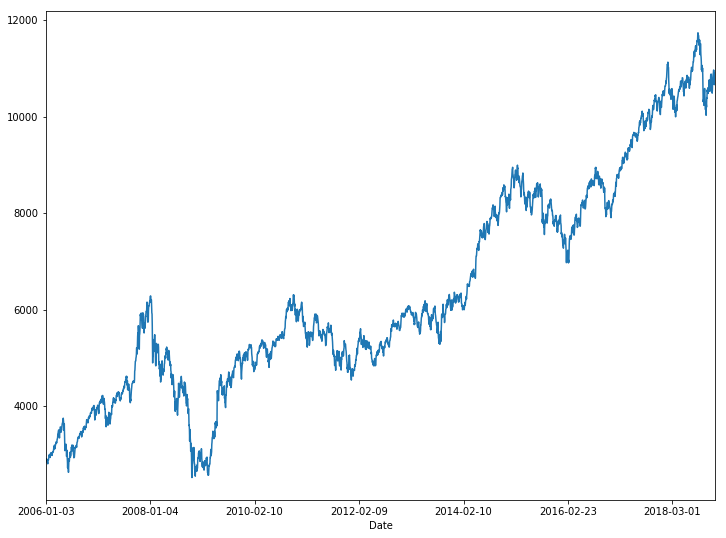

In [5]:
cl['Close'].plot(figsize=(12,9))

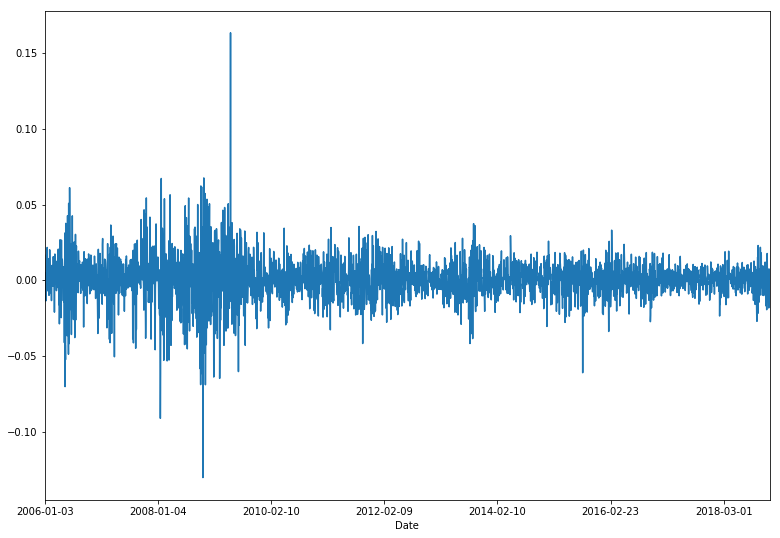

In [6]:
cl['diffLogClose'].plot(figsize=(13,9))


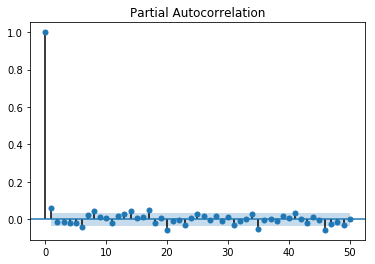

In [7]:
plot_pacf(cl['diffLogClose'], lags=50 )
plt.show()

In [8]:
def with_feedback(values):
    split=25
    train, test = values[:-split], values[-split:]
    model = AR(train)
    model_fit = model.fit(ic='bic')
    k = model_fit.k_ar
    coef = model_fit.params
    print(coef, len(coef))
    window = deque(train[-k:], maxlen=k)
    print(len(window))
    predictions = list()
    for i in range(split):
        window.reverse()
        val = coef[0]
        for j in range(k):
            val += coef[j+1]*window[j]
        predictions.append(val)
        window.reverse()
        window.append(test[i])
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    error = mean_squared_error(test, predictions)
    print("MSE for with_feedback: %.3f"%error)


In [9]:
def without_feedback(values):

    split=25
    train, test = values[:-split], values[-split:] 
    print(len(values), len(train), len(test))
    #Fit to an AR model
    model = AR(train)
    model_fit = model.fit(ic='bic')
    window = model_fit.k_ar
    coef = model_fit.params
    print(window)
    print(coef)
    
    predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    
    for i in range(len(predict)):
        print('predicted=%f, expected=%f' % (predict[i], test[i]))
    error = mean_squared_error(test, predict)
    print('Test MSE: %.3f' % error)
    plt.plot(test)
    plt.plot(predict, color='red')
    plt.show()


In [10]:
values = cl['diffLogClose'].values

3206 3181 25
1
[0.00038617 0.05839537]
predicted=0.000948, expected=0.005349
predicted=0.000442, expected=0.004039
predicted=0.000412, expected=0.012030
predicted=0.000410, expected=0.001661
predicted=0.000410, expected=0.000643
predicted=0.000410, expected=-0.001310
predicted=0.000410, expected=-0.007999
predicted=0.000410, expected=-0.016999
predicted=0.000410, expected=0.008692
predicted=0.000410, expected=-0.019380
predicted=0.000410, expected=0.005771
predicted=0.000410, expected=0.017706
predicted=0.000410, expected=0.005012
predicted=0.000410, expected=0.001287
predicted=0.000410, expected=0.007643
predicted=0.000410, expected=0.001867
predicted=0.000410, expected=0.005357
predicted=0.000410, expected=-0.001423
predicted=0.000410, expected=-0.018217
predicted=0.000410, expected=-0.008451
predicted=0.000410, expected=0.006203
predicted=0.000410, expected=0.004644
predicted=0.000410, expected=0.007403
predicted=0.000410, expected=0.000244
predicted=0.000410, expected=0.004368
Test

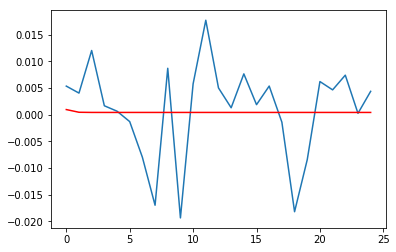

In [11]:
without_feedback(values)

[0.00038617 0.05839537] 2
1


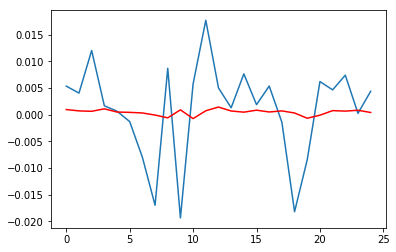

MSE for with_feedback: 0.000


In [12]:
with_feedback(values)

In [13]:
model = AR(values)
mf = model.fit(ic='bic')
print("k_ar %d"%mf.k_ar)
print("coeff ")
print(mf.params[1:])
print("normalized_cov_params")
print(mf.normalized_cov_params)
x1var = mf.normalized_cov_params[(0,0)]
x2var = mf.normalized_cov_params[(1,1)]
mf.params[1:] + np.matmul(np.array([[-1.96],[1.96]]), np.array([[x1var, x2var]]))
#if zero is part of confidence intervals, then it reduces confidence that it is a true AR(p) process

k_ar 1
coeff 
[0.05860645]
normalized_cov_params
[[ 3.12280635e-04 -6.39964028e-04]
 [-6.39964028e-04  1.52730459e+00]]


array([[ 0.05799438, -2.93491054],
       [ 0.05921852,  3.05212345]])

In [14]:
np.array([1,2]) + np.array([[1,2],[3,4]])

array([[2, 4],
       [4, 6]])

In [15]:
np.matmul(np.array([[-1.96],[1.96]]), np.array([[x1var, x2var]]))
np.ndarray((3,1))
# values = generate_ar1()
values = cl['diffLogClose'].values

In [21]:
def test_ar_p(values):
    model = AR(values)
    mf = model.fit(ic='t-stat')
    print("k_ar = ", mf.k_ar)
    print("coeff = ",mf.params)
    print("normalized_cov_params\n", mf.normalized_cov_params)
    k = mf.k_ar
    coeff = mf.params[1:]
    covp = mf.normalized_cov_params
    variances = []
#     print(variances)
    for i in range(k):
        variances.append(covp[(i,i)])
    variances = np.array(variances).reshape(1,k)
#     print(coeff)
    confint = coeff + np.matmul(np.array([[-1.96],[1.96]]), variances)
    print("Confidence Intervals")
    confint = np.transpose(confint)
    print(confint)
    
    #Check if 0 is contained in confint.
    for i,row in enumerate(confint):
        if row[0] <= 0 <= row[1]:
            print("Zero is contained in confidence interval for parameter %d"%(i+1))

In [22]:
test_ar_p(values)

k_ar =  23
coeff =  [ 0.00038858  0.05580523 -0.0172533  -0.01619463 -0.02103443 -0.02193591
 -0.03931547  0.02247424  0.04534052  0.00974919  0.01251999 -0.01644724
  0.01542761  0.03028679  0.0405894   0.00428917  0.00563697  0.04671886
 -0.02495409  0.00918837 -0.05671937 -0.008046   -0.00596751 -0.03179429]
normalized_cov_params
 [[ 3.19693979e-04 -5.95785726e-04 -5.54553083e-04 -5.56894873e-04
  -5.24646456e-04 -5.44742009e-04 -5.44781198e-04 -6.12878187e-04
  -6.06568609e-04 -5.82561498e-04 -5.98861514e-04 -6.11031575e-04
  -6.40193450e-04 -6.16257626e-04 -5.96660921e-04 -5.70628008e-04
  -6.06218705e-04 -6.09907918e-04 -5.59369331e-04 -5.63412599e-04
  -5.47150501e-04 -5.70042056e-04 -5.67033330e-04 -6.06861692e-04]
 [-5.95785726e-04  1.56091901e+00 -8.70469219e-02  2.65674984e-02
   2.30658008e-02  3.28059956e-02  3.31859597e-02  6.29042393e-02
  -3.52946699e-02 -7.09475703e-02 -1.28586306e-02 -1.85230308e-02
   2.53152734e-02 -2.44043544e-02 -4.65679787e-02 -6.25489940e-02
  -

[0.00038617 0.05839537] 2
1


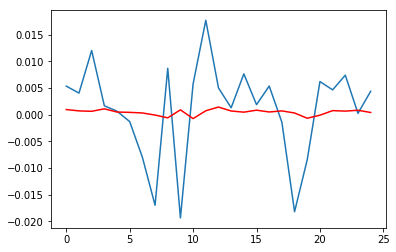

MSE for with_feedback: 0.000


In [18]:
with_feedback(values)